# Count $<i,j>$ pairs as inputs to learn Node Embedding

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy.io import loadmat
from random import choices
import copy
from scipy.sparse import issparse
from statistics import mean,stdev

## 1. Transform edgelist to Graph

In [2]:
def load_matfile(file_, variable_name="network", unDirected=True, unWeighted = True):
    mat_variables = loadmat(file_)
    mat_matrix = mat_variables[variable_name]
    if issparse(mat_matrix):
        if unDirected:
            G = nx.Graph()
        else:
            G = nx.DiGraph()
        '''
        from_nodes: cx.row
        to_nodes: cx.col
        link weights: cx.data
        '''
        cx = mat_matrix.tocoo()
        if unWeighted:
            edge_list = np.array([cx.row, cx.col]).T
            G.add_edges_from(edge_list)
        else:
            edge_list = np.array([cx.row, cx.col, cx.data]).T
            G.add_weighted_edges_from(edge_list)
    return G

In [3]:
def percolate(G, beta, unWeighted=True):
    '''
    Here we don't consider Directed/Weighted graph 
    
    '''
    edges_percolated = []
    G_percolated = nx.Graph()
    assert(G_percolated.number_of_nodes() == 0)
    numPercolatedEdges = int(beta*G.number_of_edges())
    G_percolated.add_nodes_from(list(G.nodes))
    if unWeighted:
        edges_percolated = choices(list(G.edges), k=numPercolatedEdges)
        assert(len(edges_percolated) ==  numPercolatedEdges)
        G_percolated.add_edges_from(edges_percolated)
#     else:
#         bond percolation probability depends on the edge's weight
    return G_percolated

## 2. Do statistics on cluster/Gc sizes  w.r.t betas

In [5]:
def count_clusters(G, beta, numIter, threshold):
    Gc_sizes = []
    Clusters_sizes = []
    for i in range(numIter):
        G_percolated = percolate(G, beta)
        clusters = []
        # nx.connected_component_subgraphs is a iterator
        for c in list(nx.connected_component_subgraphs(G_percolated)):
            if c.number_of_nodes() > threshold:
                size = c.number_of_nodes()
                clusters.append(size)     
                Clusters_sizes.append(size)
                
        Gc_sizes.append(max(clusters))
        
    return Gc_sizes, Clusters_sizes

In [6]:
def do_ClustersStatistics(G, betas, numIter, threshold, logging):
    GcSizes_betas = []
    ClustersSizes_betas = []
    for beta in betas:
        Gc_sizes, Clusters_sizes = count_clusters(G = G, 
                                                  beta = beta,
                                                  numIter = numIter,
                                                  threshold=threshold)
        GcSizes_betas.append(Gc_sizes)
        ClustersSizes_betas.append(Clusters_sizes)
        if logging:
            print("beta = {0:.4f} calculated".format(beta))
    return GcSizes_betas,ClustersSizes_betas

In [7]:
if __name__ == "__main__":
    # "blogcatalog.mat" is a undirected, unweighted graph
    G_blogcatalog = load_matfile(file_ = "blogcatalog.mat")
    assert(G_blogcatalog.number_of_nodes() == 10312)
    assert(G_blogcatalog.number_of_edges() == 333983)
    
    # percolate
    betas = np.linspace(0.0025,0.004, 16)#np.linspace(0.002,0.01,21)
    GcSizes_betas,ClustersSizes_betas = do_ClustersStatistics(G = G_blogcatalog, 
                                                              betas = betas, 
                                                              numIter = 2, 
                                                              threshold = 10, 
                                                              logging=False)

NameError: name 'do_ClustersStatistics' is not defined

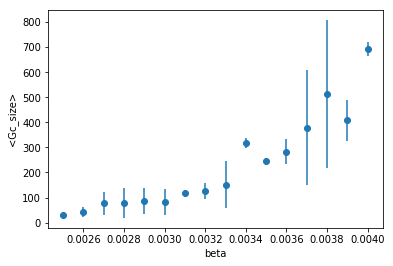

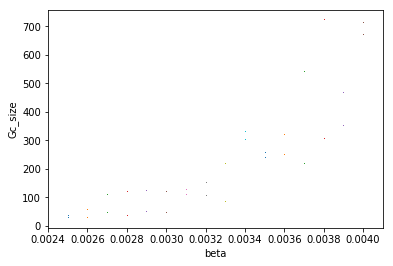

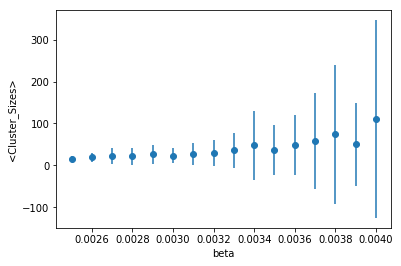

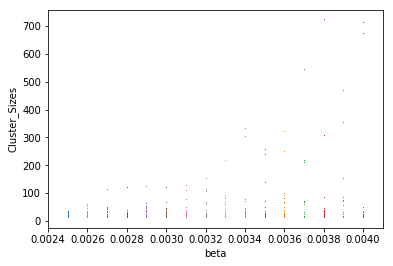

In [8]:
def plot_averGcSizes(GcSizes_betas, betas):
    plt.figure(1)
    Gc_data = np.array([[mean(sizes),stdev(sizes)] for sizes in GcSizes_betas])
    # y is meanOfSizes, yerr is stdevOfSizes
    plt.errorbar(x = betas, y = Gc_data[:,0], yerr = Gc_data[:,1], fmt='o')
    plt.xlabel('beta')
    plt.ylabel('<Gc_size>')

def plot_GcSizes(GcSizes_betas, betas):
    plt.figure(2)
    for i,beta in enumerate(betas):
        plt.plot([beta]*len(GcSizes_betas[i]),GcSizes_betas[i], ',')
#         plt.scatter([beta]*len(GcSizes_betas[i]),GcSizes_betas[i], s = 100,facecolors = 'none', edgecolors='r')
    plt.xlabel('beta')
    plt.ylabel('Gc_size')
    plt.xlim(min(betas)-0.0001,max(betas)+0.0001)
def plot_averClustersSizes(ClustersSizes_betas, betas):
    plt.figure(3)
    CS_data = np.array([[mean(sizes),stdev(sizes)] for sizes in ClustersSizes_betas])
    # y is meanOfSizes, yerr is stdevOfSizes
    plt.errorbar(x = betas, y = CS_data[:,0], yerr = CS_data[:,1], fmt='o')
    plt.xlabel('beta')
    plt.ylabel('<Cluster_Sizes>')
def plot_ClustersSizes(ClustersSizes_betas, betas):
    plt.figure(4)
    for i,beta in enumerate(betas):
            plt.plot([beta]*len(ClustersSizes_betas[i]),ClustersSizes_betas[i],',')
#             plt.scatter([beta]*len(ClustersSizes_betas[i]),ClustersSizes_betas[i],s = 100, facecolors = 'none', edgecolors='r')
    plt.xlim(min(betas)-0.0001,max(betas)+0.0001)
#     plt.ylim([0,100])
    plt.xlabel('beta')
    plt.ylabel('Cluster_Sizes')

plot_averGcSizes(GcSizes_betas, betas)
plot_GcSizes(GcSizes_betas, betas)
plot_averClustersSizes(ClustersSizes_betas, betas)
plot_ClustersSizes(ClustersSizes_betas, betas)

## 3. Calculate numOfClusters w.r.t betas & size_thresholds

In [11]:
def cal_numClusters(G, betas, thresholds, numIter):
    aver_numClusters = np.zeros([len(betas),len(thresholds)])
    for n in range(numIter):
        numClusters = np.zeros([len(betas),len(thresholds)])
        for b,beta in enumerate(betas):  
            G_percolated = percolate(G, beta)
            numClusters_ts = np.zeros([1,len(thresholds)])
            # nx.connected_component_subgraphs is a iterator
            sizes = [c.number_of_nodes() for c in list(nx.connected_component_subgraphs(G_percolated))]
            for t,threshold in enumerate(thresholds):
                sizes_t = [s for s in sizes if s > threshold]
                numClusters_ts[:,t] = sum(sizes_t)-max(sizes_t)
            numClusters[b] = numClusters_ts
        print("num_iter = ", n)
        aver_numClusters += numClusters
    return aver_numClusters/numIter

In [ ]:
if __name__ == "__main__":
    betas2 = np.linspace(0.002,0.03, 28)
    thresholds = [1,5,10,15]
    numClusters2 = cal_numClusters(G = G_blogcatalog, 
                                  betas = betas2, 
                                  thresholds = thresholds, 
                                  numIter = 1)

In [10]:
def plot_numClusters(numClusters, betas, thresholds):
    data_numClusters = np.array(numClusters).T
    fig,ax = plt.subplots(1,4,figsize = [20,10],sharey=False)

    for i,t in enumerate(thresholds):
        ax[i].plot(betas, data_numClusters[i,:])
        ax[i].set_xlim(min(betas)-0.0001,max(betas)+0.0001)
#         ax[i].set_ylim(0,1300)
        ax[i].set_title("threshold = "+str(t))
    
plot_numClusters(numClusters2,
                 betas = betas2, 
                 thresholds = thresholds)

NameError: name 'numClusters2' is not defined

In [113]:
if __name__ == "__main__":
    betas3 = np.linspace(0.0025,0.004, 16)
    numClusters3 = cal_numClusters(G = G_blogcatalog, 
                                  betas = betas3, 
                                  thresholds = thresholds, 
                                  numIter = 20)

num_iter =  0
num_iter =  1
num_iter =  2
num_iter =  3
num_iter =  4
num_iter =  5
num_iter =  6
num_iter =  7
num_iter =  8
num_iter =  9
num_iter =  10
num_iter =  11
num_iter =  12
num_iter =  13
num_iter =  14
num_iter =  15
num_iter =  16
num_iter =  17
num_iter =  18
num_iter =  19


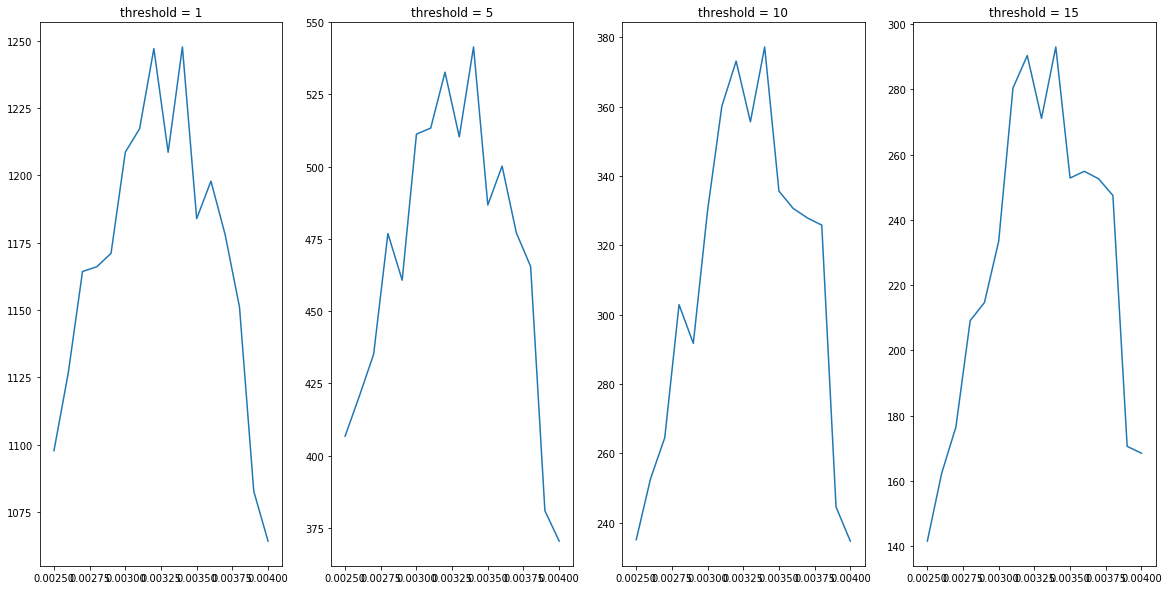

In [114]:
def plot_numClusters(numClusters, betas, thresholds):
    data_numClusters = np.array(numClusters).T
    fig,ax = plt.subplots(1,4,figsize = [20,10],sharey=False)

    for i,t in enumerate(thresholds):
        ax[i].plot(betas, data_numClusters[i,:])
        ax[i].set_xlim(min(betas)-0.0001,max(betas)+0.0001)
#         ax[i].set_ylim(0,1300)
        ax[i].set_title("threshold = "+str(t))
    
plot_numClusters(numClusters3,
                 betas = betas3, 
                 thresholds = thresholds)

In [46]:
def gen_clusters(G, threshold, beta):
    clusters = []
    G_percolated = percolate(G, beta)
    for c in nx.connected_component_subgraphs(G_percolated):
        if c.number_of_nodes() > threshold:
            clusters.append(list(c.nodes()))
    return clusters

In [53]:
if __name__ == "__main__":
    all_clusters = []
    num_percolate = 0

In [48]:
if __name__ == "__main__":
    num_percolate += 500
    for i in range(500):
            clusters = gen_clusters(G = G_blogcatalog,
                                    threshold = 1,
                                    beta = 0.0036)
            all_clusters += clusters
#             if i == 0:
#                 numOfClusters = len(clusters)
#                 numNodesInClusters = sum([len(c) for c in clusters])

In [49]:
def count_nodes_sizes(G, numNodes, all_clusters):
    nodes = list(G.nodes())
    nodes_in_clusters = {v: [] for v in nodes}
    for c in all_clusters:
        for v in c:
            nodes_in_clusters[v].append(len(c))
    chosen_nodes = choices(nodes,k = numNodes)
    return nodes_in_clusters, chosen_nodes

nodes_in_clusters,chosen_nodes = count_nodes_sizes(G = G_blogcatalog,
                                                   all_clusters = all_clusters,
                                                   numNodes = 100)

(0, 40)

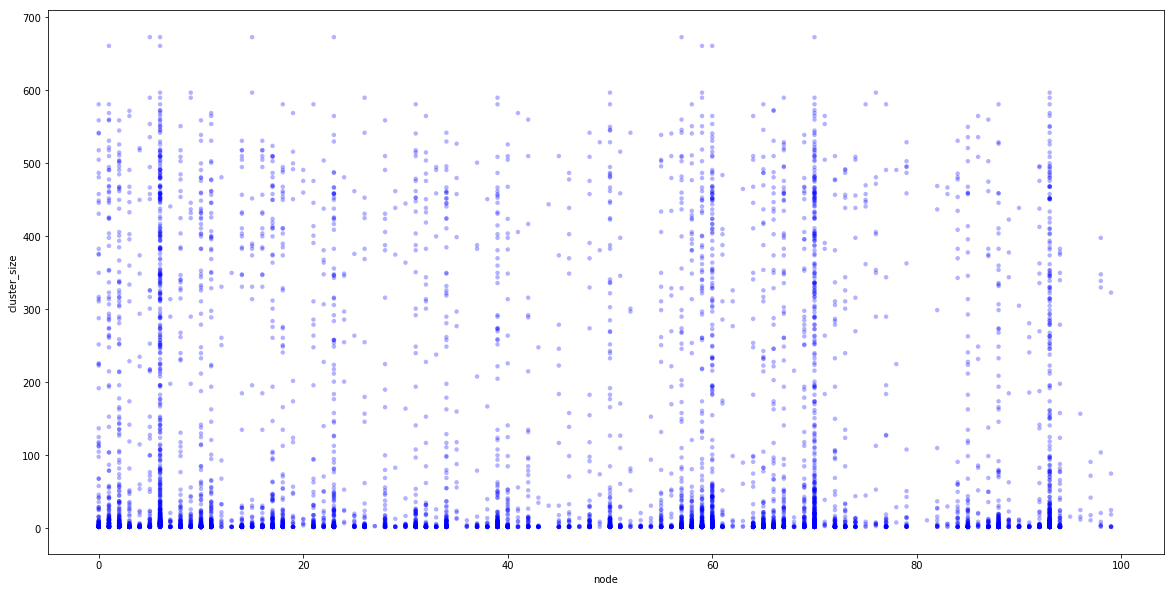

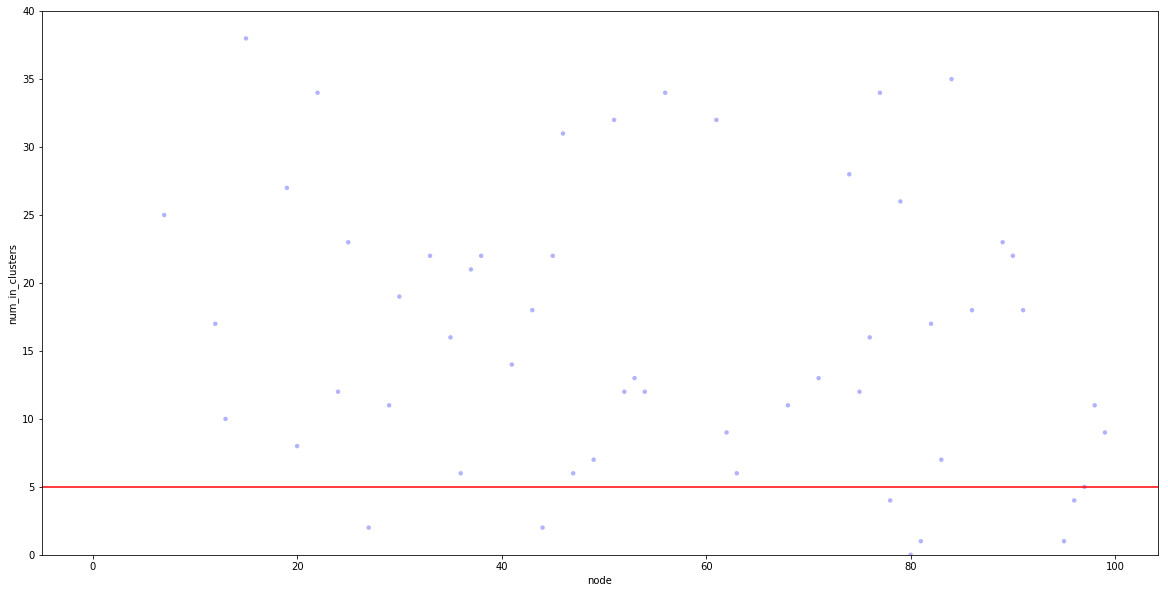

In [50]:
plt.figure(6,figsize=[20,10])
for i,v in enumerate(chosen_nodes):
#     plt.plot(len(nodes_in_clusters[v])*[i], nodes_in_clusters[v], ',')
    plt.scatter(len(nodes_in_clusters[v])*[i], nodes_in_clusters[v], s = 20, facecolors = 'blue', edgecolors="none",alpha=0.3)
plt.xlabel("node")
plt.ylabel("cluster_size")
# plt.ylim()

plt.figure(7,figsize=[20,10])
for i,v in enumerate(chosen_nodes):
    plt.scatter(i, len(nodes_in_clusters[v]), s = 20, facecolors = 'blue', edgecolors="none",alpha=0.3)
#     plt.plot(i, len(nodes_in_clusters[v]), 'bo',)

plt.axhline(y=5, color='r', linestyle='-')
plt.xlabel("node")
plt.ylabel("num_in_clusters")
plt.ylim(0,40)


In [51]:
with open('Gblog_beta0036_iter500.txt', 'a') as fh:
    for cluster in all_clusters:
        fh.writelines("{:s}\n".format(" ".join([str(node) for node in cluster])))